In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from tmu.models.autoencoder.autoencoder import TMAutoEncoder

np.seterr(divide='ignore', invalid='ignore')

2025-02-24 14:30:33,688 - tmu.util.cuda_profiler - WARNING - Could not import pycuda: No module named 'pycuda'
2025-02-24 14:30:33,689 - tmu.clause_bank.clause_bank_cuda - ERROR - No module named 'pycuda'
Traceback (most recent call last):
  File "/Users/kjellhaaland/Documents/GitHub/uia-master-thesis/.venv/lib/python3.12/site-packages/tmu/clause_bank/clause_bank_cuda.py", line 41, in <module>
    from pycuda._driver import Device, Context
ModuleNotFoundError: No module named 'pycuda'
2025-02-24 14:30:33,690 - tmu.clause_bank.clause_bank_cuda - WARNING - Could not import pycuda. This indicates that it is not installed! A possible fix is to run 'pip install pycuda'. Fallback to CPU ClauseBanks.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def load_test_dataset(farm, event_id):
    X = np.loadtxt(f"./data_test/X_{farm}_{event_id}_10b.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)
    return X


def load_train_dataset(farm, event_id):
    X = np.loadtxt(f"./data_train/X_{farm}_{event_id}_10b.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)

    # Take only the first 2000 rows
    X = X[:2000]

    return X


def load_test_labels(farm, event_id):
    y = np.loadtxt(f"./data_test/y_{farm}_{event_id}_10b.txt", dtype=np.uint32)
    y = np.array(y).astype(np.uint32)
    return y


def load_train_labels(farm, event_id):
    y = np.loadtxt(f"./data_train/y_{farm}_{event_id}_10b.txt", dtype=np.uint32)
    y = np.array(y).astype(np.uint32)

    # Take only the first 2000 rows
    y = y[:2000]

    return y

In [3]:
def load_model(filename) -> TMAutoEncoder:
    with open(filename, "rb") as f:
        model = pickle.load(f)

    return model

In [4]:
def calculate_accuracy(labels, predictions):
    # g = the ground truth of all data points with a normal status-ID within the prediction time frame
    g = labels

    # p = the corresponding prediction of an AD-model.
    p = predictions

    # Calculate the accuracy
    fp = np.sum((p == 1) & (g == 0))

    # the number of true negatives based on g and p
    tn = np.sum((p == 0) & (g == 0))

    fn = np.sum((p == 0) & (g == 1))
    tp = np.sum((p == 1) & (g == 1))

    print(f"FP: {fp}, TN: {tn}, FN: {fn}, TP: {tp}")

    accuracy = tn / (fp + tn)

    return accuracy

In [5]:
def reconstruction_accuracy(X, pred):
    # For each value of X, if the value is the same as the prediction, then it is correct
    #mse_loss = np.mean((X - pred) ** 2)

    correct = np.sum(X == pred)
    accuracy = correct / len(X)
    return accuracy


def hamming_loss(y_true, y_pred):
    return np.mean(y_true != y_pred)


def plot_mse(X, y, pred, name, threshold):
    # Compute MSE for each row
    mse_per_row = [reconstruction_accuracy(X[i], pred[i]) for i in range(len(X))]

    # Plot SNS plot of all MSE values
    plt.figure(figsize=(8, 4))
    sns.histplot(mse_per_row, bins=50, kde=True, color='b')

    # Add a threshold line
    plt.axvline(threshold, color='r', linestyle='--')

    # Save the plot
    plt.savefig(f"./plot_mse_hist_{name}.png")


def run_test(X, y, name):
    print(f"Experiment: {name}")
    print(f"Rows: {len(X)}, Columns: {len(X[0])}")

    tm = load_model("latest_big_2.pkl")

    pred = tm.predict(X)

    threshold = 0.52

    # For each row in pred, if the MSE is greater than the threshold, then it is an anomaly
    reconstruction_accuracies = [reconstruction_accuracy(X[i], pred[i]) for i in range(len(X))]

    # Print average reconstruction accuracy
    print(f"Average Reconstruction Accuracy: {np.mean(reconstruction_accuracies)}")

    X_predictions = np.array([1 if reconstruction_accuracies[i] > threshold else 0 for i in range(len(X))])

    # Accuracy
    accuracy = calculate_accuracy(y, X_predictions)

    print(f"Accuracy: {accuracy}")

    plot_mse(X, y, pred, name, threshold=threshold)

In [6]:
X_train = load_train_dataset("C", 49)
y_train = load_train_labels("C", 49)

X_test = load_test_dataset("C", 49)
y_test = load_test_labels("C", 49)

Experiment: 49_train
Rows: 2000, Columns: 2380
Average Reconstruction Accuracy: 0.7231006302521009
FP: 2000, TN: 0, FN: 0, TP: 0
Accuracy: 0.0
Experiment: 49_test
Rows: 598, Columns: 2380
Average Reconstruction Accuracy: 0.7492011185745201
FP: 0, TN: 0, FN: 0, TP: 598
Accuracy: nan


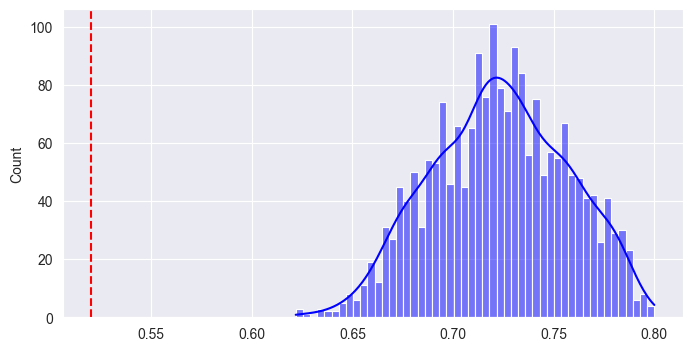

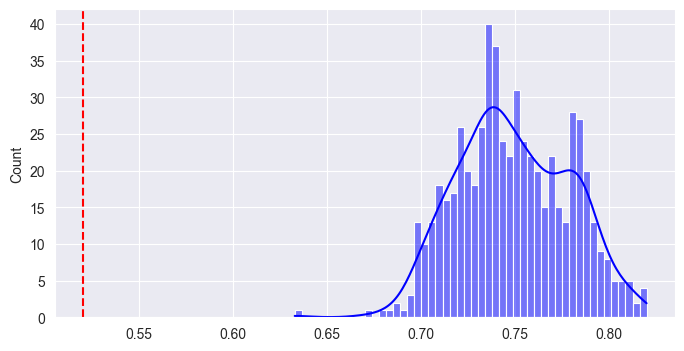

In [7]:
run_test(X_train, y_train, "49_train")
run_test(X_test, y_test, "49_test")